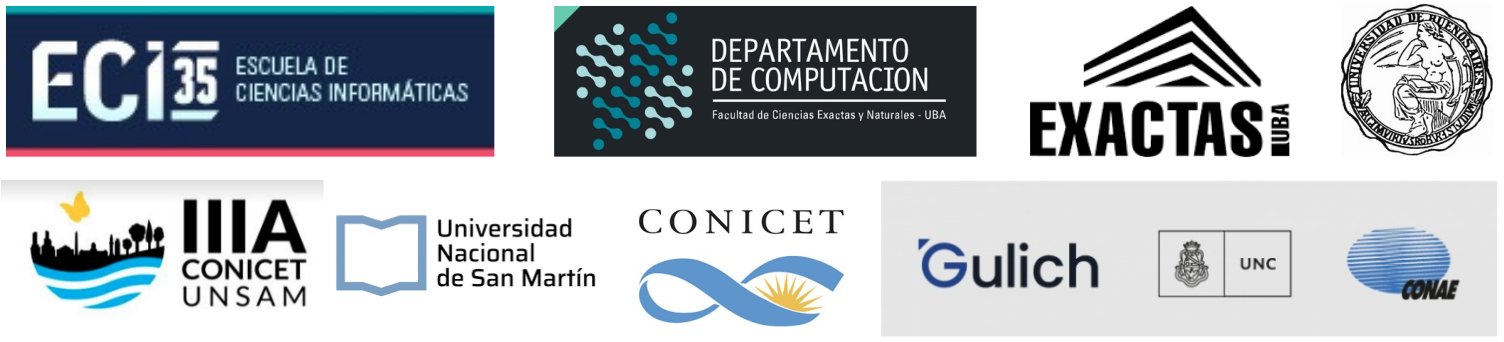
# Escuela de Ciencias Informáticas - 2022 - DC - FCEN - UBA
## Curso: Procesamiento de Imágenes Satelitales.  Docente: Rafael Grimson


---
#  Notebook 6: Integración de datos vectoriales y raster. 
---
Lo que veremos en esta notebook:

- [x] Recordamos lectura y visualización de rasters
- [x] Visualización conjunta de datos vectoriales y rasters
- [x] Recortes de rasters por polígonos vectoriales. Guardar los recortes.
---


### Objetivos de la notebook:

Luego de haber aprendido algunas operaciones de manejo básico de datos vectoriales, en esta notebook veremos algunas nociones básicas sobre cómo integrarlos con datos raster. Seguiremos usando `geopandas` y `rasterio` como bibliotecas centrales.

### Datos con los que trabajaremos en esta notebook:


- Imagen SPOT 7 con la que trabajamos en la clase anterior, calibrada a reflectancia a tope de la atmósfera (**data/raw_data/SPOT_20170806_MS_p.tif**).
- Una imagen Sentinel-2 de la misma zona de estudio (archivo **data/raw_data/S2_20180619_2-3-4-8-11-12.tif**).
- Capa vectorial de rutas y cursos de agua que atraviesan la zona de estudio.
- Capa vectorial de radios censales con las transformaciones realizadas en la notebook anterior.

## 1. Lectura de archivos raster con Rasterio

Para comenzar, levantaremos nuestras imagen Sentinel-2 (archivo **S2_20180619_2-3-4-8-11-12.tif**) con Rasterio y leeremos algunas de sus propiedades para entender cómo las interpreta esta biblioteca respecto a lo que vimos en las Clases 02 y 03.

La imagen Sentinel 2 que hemos preparado para esta notebook contiene 6 bandas:

- Banda 1: Azul
- Banda 2: Verde
- Banda 3: Rojo
- Banda 4: Infrarrojo Cercano (NIR)
- Banda 5: Infrarrojo de Onda Corta 1 (SWIR 1)
- Banda 6: Infrarrojo de Onda Corta 2 (SWIR 2).

Más especificaciones sobre las bandas de Sentinel 2 se pueden encontrar en [este enlace](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import rasterio
import geopandas as gpd
import numpy as np


s2 = rasterio.open('data/raw_data/S2_20180619_2-3-4-8-11-12.tif')


Como se puede ver, tanto GDAL como Rasterio traducen a las imágenes en clases, sobre las que podremos aplicar ciertos métodos y que tendrán ciertos atributos. En esos métodos y atributos radican las principales diferencias entre ambas librerías. Veamos como se leen algunos de los principales atributos con Rasterio:

In [ ]:
#Proyección
print(s2.crs)

In [ ]:
#Geotransform:
print(s2.transform)

In [ ]:
# Dimensiones y cantidad de bandas
print(s2.width)
print(s2.height)
print(f'Número de bandas: {s2.count}')

In [ ]:
#Extensión:
print(s2.bounds)

In [ ]:
#Metadatos:
print(s2.meta)

En este último parámetro (metadatos) se resume toda la información del Raster, con estructura de diccionario. Cuando escribamos imágenes modificadas vamos a editar principalmente este atributo. 

Para leer las bandas como matrices o arreglos de Numpy, el código es muy parecido a GDAL:

In [ ]:
s2_bandas = s2.read()

s2_bandas.shape

Corroboramos que se ha leido correctamente usando la función **plot_rgb** que creamos en la Clase 3:

In [ ]:
from funciones import *
plot_rgb(s2_bandas, [2,1,0], p = 5, title = 'Sentinel-2 RGB')
plot_rgb(s2_bandas, [5,3,2], p = 2, title = 'Sentinel-2 SWIR2 NIR R')

## 2. Visualización de datos vectoriales y raster en conjunto

Ahora vamos a abrir nuestro vector de radios censales (puede ser el archivo **radios_merge_viv_personas.shp** o su análogo en formato Geopackage, o también el archivo **radios_recorte_utm.shp** original) trabajado en la Notebook anterior, y lo vamos a superponer con nuestra imagen Sentinel. ¡A ver cómo nos va!

Plotear datos vectoriales y raster por separado en Python es relativamente sencillo. Sin embargo, cuando los queremos ver en conjunto hay que tener en cuenta la extensión espacial (o _extent_ in inglés) que debe ocupar cada uno en la figura. También es importante que las capas tengan la misma proyección (o _CRS_ para Rasterio).

In [ ]:
# Usemos el código del radio censal cono índice
radios = gpd.read_file('data/raw_data/vector/radios_recorte_utm.shp').set_index('link')

In [ ]:
print(s2.crs)
print(radios.crs)

¡Bien! Las capas tienen el mismo CRS. Ahora, para que podamos superponer las dos fuentes de información en el mismo gráfico, debemos explicitar cuál será la extensión a graficar con el parámetro **extent**. Para ello, primero usaremos una función de Rasterio que nos permite obtener esos límites:

In [ ]:
from rasterio.plot import plotting_extent
s2_plot_extent = plotting_extent(s2)

s2_plot_extent

Los valores del _extent_ de nuestra imagen no difieren mucho de lo que nos devuelve **bounds**. Sin embargo, **plot_extent** devuelve una tupla con un orden de coordenadas que Matplotlib puede interpretar correctamente:

In [ ]:
print(type(s2.bounds))
print(type(s2_plot_extent))

Probemos ahora superponer los radios con imagen Sentinel-2 en RGB:

In [ ]:
from matplotlib import pyplot as plt

img = nequalize(s2_bandas[[2,1,0]])
fig, ax = plt.subplots(figsize = (12,6))
show(img, ax=ax, extent = s2_plot_extent, cmap = 'gray')
radios.plot(ax=ax)
plt.show()

A simple vista pareciera que solo se graficaron los polígonos de los radios censales. Sin embargo, la imagen está también, solo que por debajo. Si aplicamos un poco de transparencia al vector la vamos a ver:

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
show(img,ax=ax, extent = s2_plot_extent, cmap = 'gray')
radios.plot(ax=ax, alpha = 0.5)
plt.show()

Para evitar tener que hacer desaparecer nuestra capa de radios, podemos usar el atributo **boundary** para plotear solo sus bordes, y darles un color que resalte bien con el parámetro **edgecolor**:

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
show(img,ax=ax, extent = s2_plot_extent, cmap = 'gray')
radios.boundary.plot(ax=ax, edgecolor = 'red')
plt.show()

Podemos también superponerlo con un RGB, para lo cual podemos generar primero un stack listo para plotear con nuestra función nequalize.

### Ejercicio 6.1:

a) Leer los vectores que corresponden al Río Suquía (**data/raw_data/vector/rio_suquia_utm.shp**) y a red de accesos a Córdoba (**data/raw_data/vector/red_nacional_recorte_utm**) y graficarlos junto a la imagen Sentinel 2 y los polígonos de radios censales.

**Nota:** Se puede jugar con el parámetro **_zorder_** para cambiar el orden en que se grafican las distintan capas. [Aquí](https://matplotlib.org/3.1.1/gallery/misc/zorder_demo.html) pueden consultar una página específica donde se explica el funcionamiento de este parámetro.

## 3. Recorte de archivos raster a partir de vectores

Anteriormente vimos una manera de realizar recortes de nuestras imágenes como _subsets_ rectangulares o cuadrados, aplicando el _slicing_ de `numpy`. Ahora veremos una manera de hacerlo con `rasterio` utilizando polígonos georeferenciados (datos vectoriales). 

Supongamos que queremos usar el polígono de radio censal resaltado en amarillo en la captura para recortar nuestro raster:

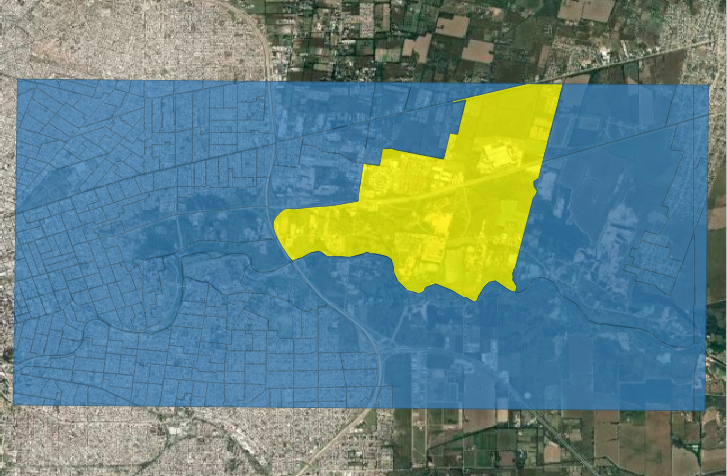

Si consultamos sus atributos en QGIS, ese polígono corresponde al Radio 5, Fracción 7, o al valor '140140705' en la columna **link**.

Lo que haremos primero entonces es crear un filtro de nuestro GeoDataframe que contenga solo ese polígono: eso lo podemos hacer a partir de uno de los atributos del mismo:

In [ ]:
poligono = radios.loc[140140705].geometry

In [ ]:
poligono

Ya tenemos nuestro polígono individualizado. Tenemos dos maneras de hacer nuestro "recorte":

    A) Usando la extensión espacial del polígono (con lo cual obtendríamos un rectángulo o cuadrado)

    B) Usando los límites exactos del polígono. En ese caso sería un recorte sumado a una operación de enmascarado.

### A. Corte por extensión espacial

En el caso de A, la extensión espacial se refiere siempre al borde o línea que une las coordenadas más extremas en Norte,Sur, Este y Oeste. La siguiente figura (extraída de [esta página](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/)) lo muestra más claramente para el caso de vectores:

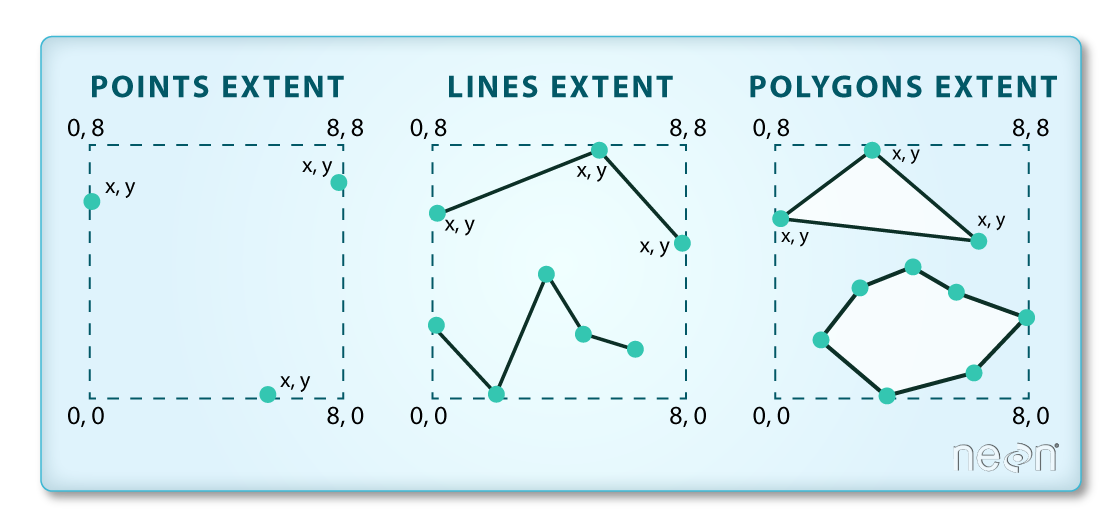

Nuestro polígono tiene su propia envolvente, definida por *_envelope_*:

In [ ]:
extent = poligono.envelope
extent

In [ ]:
data = [poligono, extent]
gpd.GeoSeries(data).boundary.plot(color=['b', 'r'])

Ahora usamos **extent_geo** para hacer el recorte con la función **mask** de Rasterio:

In [ ]:
from rasterio.mask import mask

s2_clip, clip_transform = mask(dataset = s2, shapes = [extent], crop = True)

In [ ]:
print(clip_transform)

**Mask** nos devuelve el archivo recortado como arreglo de Numpy (lo hemos llamado **s2_clip**) y su _GeoTransform_ ya calculado (lo hemos asignado parámetro cuando querramos guardar el recorte.

In [ ]:
plot_rgb(s2_clip, [2,1,0], p=2)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_clip[[2,1,0]]), ax=ax,transform=clip_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por extent \n Combinación bandas S2 RGB")
plt.show()

### B. Corte por máscara

Veamos ahora como funciona la opción B, es decir recortar haciendo un **enmascarado**.

En este caso, en vez de usar el Extent, directamente usamos los límites exactos de nuestro polígono. El raster resultante **sigue siendo una matriz rectangular**, pero todos los píxeles que caen por fuera de la máscara (el polígono) quedan como valores Sin datos. La geometría que aplicamos ahora es directamente la del Geodataframe **poligono**:

In [ ]:
s2_mask, mask_transform  = mask(dataset = s2, shapes = [poligono], crop = True)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_mask[[2,1,0]]), ax=ax,transform=mask_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por polígono \n Combinación bandas S2 RGB")
plt.show()

Esto se ve bastante diferente a **s2_clip** , verdad? Sin embargo, si imprimimos sus dimensiones son exactamente iguales:

In [ ]:
print(s2_clip.shape)
print(s2_mask.shape)

Lo que cambia es que ahora por afuera de los bordes de la máscara, tenemos todos píxeles con valor 0. Nosotros en realidad querríamos que sean píxeles sin datos, por lo tanto a la hora de guardar el raster recortado, lo vamos a tener que explicitar en sus metadatos.

### Escritura de los recortes en nuestro sistema

Ahora resta guardar estos recortes en nuestra disco. Ya definimos la función   `guardar_GTiff()`. La vamos a usar indicando como metadatos `{'dtype': 'uint16', 'nodata':0}` para que guarde enteros de 16bits (y no desperidice espacio guardándoloes como flot32) y funcione la máscara usando 0 como valores de no-dato. 

In [ ]:
s2.meta

De todos los metadatos de la imagen Sentinel-2 completa, solo debemos cambiar los parámetros 'width' , 'height' y 'transform'. También, y sobretodo para el raster al que le aplicamos la máscara, debemos explicitar que tome al 0 como valor sin datos. Podemos re-definir los metadatos copiando y pegando la salida de arriba, y modificando lo que necesitamos:

In [ ]:
guardar_GTiff('data/proc/S2_clip.tif', s2.crs, clip_transform, s2_clip, meta = {'dtype': 'uint16'})
guardar_GTiff('data/proc/S2_mask.tif', s2.crs, mask_transform, s2_mask, meta = {'dtype': 'uint16', 'nodata': 0})


Podemos abrir los archivos creados en QGIS y corroborar que se hayan hecho bien los recortes:

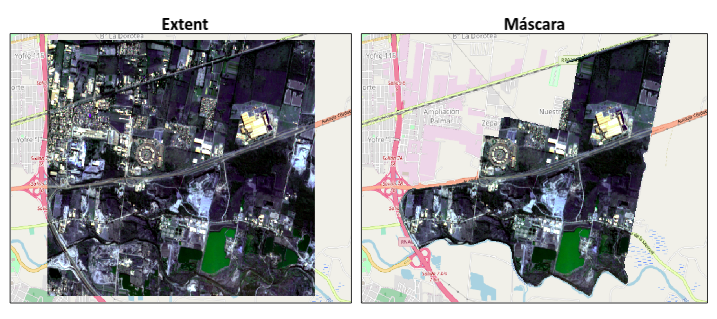

### Generalizando a más de un polígono. El método `iterrows()`.

Si quisiéramos hacer un recorte enmascarado por cada uno de los polígonos que componen la capa de radios, podríamos armar un ciclo _for_ que la vaya recorriendo, generar el recorte y guardarlo con un identificador único, que podría ser el código de cada radio. La celda de abajo puede demorar un poco en correr, pero cuando termine de ejecutarse, observá el resultado en tu carpeta **proc**:

In [ ]:
import os

for link, radio in radios.iterrows():
    poligono_radio = radio['geometry']
    recorte_masked,transform =  mask(dataset=s2,shapes = [poligono_radio], crop = True)
    ruta_out = 'data/proc'
    nombre = f'S2_mask_{link}.tif'
    outfile = os.path.join(ruta_out,nombre)
    guardar_GTiff(outfile,s2.crs,transform,recorte_masked,meta = {'dtype': 'uint16', 'nodata': 0})

### Ejercicio 6.2

b) Abrir la imagen SPOT (puede ser alguna de sus bandas, la banda pancromática o el apilado de 4 bandas) y recortarla al igual que la imagen Sentinel-2. Guardar los recortes como archivos GeoTiff. Comparar los resultados en QGIS.

b) ¿Qué sucede con los pixels que no caen compleamente dentro ni fuera del polígono de recorte?

c) Probar qué sucede con el tamaño y extensión espacial de los archivos guardados como GeoTiff cuando en el comando `mask` se configura el parámetro **crop** como False. Buscar en la documentación de `rasterio` a qué se refiere este parámetro.



### Ejercicio 6.3

a) Escribí una función `extraer_raster(raster, vectorial, atributo)` que tome como entradas un nombre de un archivo raster, un nombre de archivo vectorial de polígonos, un atributo o columna que identifique unívocamente cada polígono del archivo vectorial (como link), y un directorio de salida donde guardar los resultados. La función debe generar un recorte del raster para cada polígono en el archivo vectorial y guardarlo en el directorio de salida, utilizando el nombre original del raster+atributo como nombre de salida.

Obvio, podés ayudarte con el ejemplo anterior. 